# Maintenance Notebook: Update renaming dict for missing models

I use this notebook to identify `source_id`s that are present in the cloud storage but have not yet been entered in the central renaming_dict.

> IMPORTANT: Install `xmip` from source, so that the dict is updated as you go.

In [32]:
%load_ext autoreload
%autoreload 2
import intake
import pandas as pd
import xarray as xr
from xmip.preprocessing import cmip6_renaming_dict

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [36]:
dd = cmip6_renaming_dict()

AWI-CM-1-1-MR
{}
BCC-CSM2-MR
{'x': ['lon'], 'y': ['lat'], 'lon': ['longitude'], 'lat': ['latitude'], 'lev': ['lev'], 'bnds': ['bnds'], 'lev_bounds': ['lev_bnds'], 'lon_bounds': ['lon_bnds'], 'lat_bounds': ['lat_bnds'], 'vertex': [None], 'time_bounds': ['time_bnds']}
BCC-ESM1
{'x': ['lon'], 'y': ['lat'], 'lon': ['longitude'], 'lat': ['latitude'], 'lev': ['lev'], 'bnds': ['bnds'], 'lev_bounds': ['lev_bnds'], 'lon_bounds': ['lon_bnds'], 'lat_bounds': ['lat_bnds'], 'vertex': ['vertex'], 'time_bounds': ['time_bnds']}
CAMS-CSM1-0
{'x': ['i', 'lon'], 'y': ['j', 'lat'], 'lon': ['longitude'], 'lat': ['latitude'], 'lev': ['lev'], 'lev_bounds': ['lev_bnds'], 'lon_bounds': [None], 'lat_bounds': [None], 'vertex': ['vertices'], 'time_bounds': ['time_bnds']}
CanESM5
{'x': ['i', 'lon'], 'y': ['j', 'lat'], 'lon': ['longitude'], 'lat': ['latitude'], 'lev': ['lev'], 'lev_bounds': ['lev_bnds'], 'lon_bounds': [None], 'lat_bounds': [None], 'time_bounds': ['time_bnds'], 'vertex': ['vertices']}
CanESM5-CanOE


In [23]:
# Grab all available ocean output.
url = "https://raw.githubusercontent.com/NCAR/intake-esm-datastore/master/catalogs/pangeo-cmip6.json"
col = intake.open_esm_datastore(url)
query = dict(table_id=['Omon', 'Oyr']) # pick all available ocean fields for now
cat = col.search(**query)

# find unique source_ids
available_models = cat.df['source_id'].unique()
# find available models in xmip
models = [k for k in cmip6_renaming_dict().keys()]
# find missing models
missing_models = [m for m in available_models if m not in models]
print(missing_models)
additional_models = [m for m in models if m not in available_models]
print(additional_models)

KeyError: 'x'

In [3]:
all_variables = cat.df['variable_id'].unique()
surface_variables = ['tos', 'chl', 'zos', 'chlos', 'fgco2', 'hfds', 'sos',
                     'mlotst', 'tauuo', 'tauvo', 'msftmz', 'intpp']
remaining_variables = [v for v in all_variables if v not in surface_variables]
# some models literally have only surface input. Ill deal with that later. For now lets look at the ones that have 3d 
# output (if surface values show up below, add them to the list above.)
# now load one dataset for each missing model
query = dict(table_id=['Omon', 'Oyr'], source_id=missing_models, variable_id=remaining_variables) # pick all available ocean fields for now
cat_sub = col.search(**query)
cat_sub.df = cat_sub.df.drop_duplicates(subset='source_id')
surface_only_models = [m for m in missing_models if m not in cat_sub.df['source_id'].unique()]
if len(cat_sub.df) > 0:
    dset_dict = cat_sub.to_dataset_dict(zarr_kwargs={'consolidated': True, 'decode_times':False})
    for k, ds in dset_dict.items():
        print('=========================================')
        print(k)
        print('=========================================')
        print(ds)
        da = ds[ds.attrs['variable_id']]
        if len(da.dims) < 5:
            print('!!! This is a surface field!!!')
else:
    print('Nice. All models with 3d ocean fields are catalogued')

Nice. All models with 3d ocean fields are catalogued


Now take care of the models that have only surface fields (I will leave the depth info blank and fill in later)

In [4]:
query = dict(table_id=['Omon', 'Oyr'], source_id=surface_only_models, variable_id=surface_variables)
cat_surf = col.search(**query)
cat_surf.df = cat_surf.df.drop_duplicates(subset='source_id')

if len(cat_sub.df) > 0:
    dset_dict = cat_surf.to_dataset_dict(zarr_kwargs={'consolidated': True, 'decode_times':False})
    for k, ds in dset_dict.items():
        print('=========================================')
        print(k)
        print('=========================================')
        print(ds)
        da = ds[ds.attrs['variable_id']]
else:
    print('Nice. All ocean models are catalogued')

Nice. All ocean models are catalogued


Check out the atmos model parts

In [14]:
col.df['table_id'].unique()

array(['AERmon', 'Amon', 'Omon', 'day', 'AERmonZ', 'CFmon', 'fx', 'Lmon',
       'SImon', 'Oyr', 'LImon', 'Ofx', '3hr', '6hrLev', 'Oday', 'Aclim',
       'Emon', 'CFday', '6hrPlev', 'CF3hr', 'Oclim', 'SIclim', 'Eclim',
       'Odec', 'AERhr', 'IfxGre', 'ImonGre', '6hrPlevPt', 'E3hr'],
      dtype=object)

In [21]:
lst = ['a', 'b']

'a' in lst

[autoreload of xmip.preprocessing failed: Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/srv/conda/envs/notebook/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 394, in superreload
    module = reload(module)
  File "/srv/conda/envs/notebook/lib/python3.7/imp.py", line 314, in reload
    return importlib.reload(module)
  File "/srv/conda/envs/notebook/lib/python3.7/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 630, in _exec
  File "<frozen importlib._bootstrap_external>", line 724, in exec_module
  File "<frozen importlib._bootstrap_external>", line 860, in get_code
  File "<frozen importlib._bootstrap_external>", line 791, in source_to_code
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/home/jo

True

In [20]:
query = dict(table_id='6hrLev')
cat_atmos = col.search(**query)
cat_atmos.df = cat_atmos.df.drop_duplicates(subset='source_id')
print(cat_atmos.df)
print(len(cat_atmos.df))
if len(cat_atmos.df) > 0:
    dset_dict = cat_atmos.to_dataset_dict(zarr_kwargs={'consolidated': True, 'decode_times':False})
    for k, ds in dset_dict.items():
        print('=========================================')
        print(k)
        print('=========================================')
        print(ds)
        da = ds[ds.attrs['variable_id']]
# else:
#     print('Nice. All ocean models are catalogued')

   activity_id institution_id      source_id experiment_id  member_id  \
0         CMIP            BCC    BCC-CSM2-MR    historical   r1i1p1f1   
5         CMIP   CNRM-CERFACS     CNRM-CM6-1    historical   r1i1p1f2   
10        CMIP   CNRM-CERFACS    CNRM-ESM2-1    historical   r1i1p1f2   
15        CMIP   CSIRO-ARCCSS     ACCESS-CM2    historical   r1i1p1f1   
20        CMIP           IPSL   IPSL-CM6A-LR    historical   r1i1p1f1   
25        CMIP          MIROC         MIROC6    historical   r1i1p1f1   
30        CMIP          MPI-M  MPI-ESM1-2-HR    historical   r1i1p1f1   
35        CMIP          MPI-M  MPI-ESM1-2-LR    historical   r1i1p1f1   
40        CMIP            MRI     MRI-ESM2-0    historical   r1i1p1f1   
45        CMIP           NCAR          CESM2    historical  r10i1p1f1   
48        CMIP            NCC     NorESM2-LM    historical   r1i1p1f1   
53        CMIP      NOAA-GFDL       GFDL-CM4    historical   r1i1p1f1   
58        CMIP            SNU    SAM0-UNICON    his

# Final check if all data can be loaded and plotted properly

In [5]:
query = dict(table_id=['Omon', 'Oyr']) # pick all available ocean fields for now
cat = col.search(**query)
cat.df = cat.df.drop_duplicates(subset='source_id')

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

BCC-CSM2-MR
Progress: |███████████████████████████████████████████████████████████████████████████████| 100.0% 

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'
             
--> There are 1 group(s)
<xarray.DataArray 'tos' (member_id: 1, time: 1032, y: 232, x: 360)>
dask.array<broadcast_to, shape=(1, 1032, 232, 360), dtype=float32, chunksize=(1, 149, 232, 360), chunktype=numpy.ndarray>
Coordinates:
    lon        (y, x) float32 dask.array<chunksize=(232, 360), meta=np.ndarray>
    lat        (y, x) float32 dask.array<chunksize=(232, 360), meta=np.ndarray>
  * x          (x) float32 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
  * time       (time) int64 0 708 1416 2148 2880 ... 750420 751152 751884 752616
  * y          (y) float32 -81.5 -80.5 -79.5 ... 78.39897 78.67173 78.84094
  * member_id  (member_id) <U8 'r1i1p1f1'
Attributes:
    cell_measures:  area: areacello
   

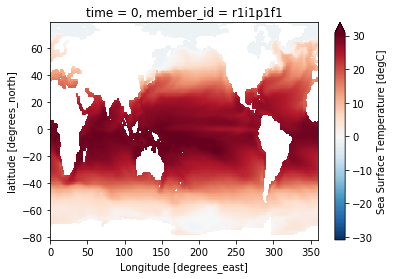

BCC-ESM1
Progress: |███████████████████████████████████████████████████████████████████████████████| 100.0% 

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'
             
--> There are 1 group(s)
<xarray.DataArray 'tos' (member_id: 1, time: 492, y: 232, x: 360)>
dask.array<broadcast_to, shape=(1, 492, 232, 360), dtype=float32, chunksize=(1, 246, 232, 360), chunktype=numpy.ndarray>
Coordinates:
    lon        (y, x) float32 dask.array<chunksize=(232, 360), meta=np.ndarray>
    lat        (y, x) float32 dask.array<chunksize=(232, 360), meta=np.ndarray>
  * x          (x) float32 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
  * time       (time) int64 0 708 1416 2148 2880 ... 356220 356952 357684 358416
  * y          (y) float32 -81.5 -80.5 -79.5 ... 78.39897 78.67173 78.84094
  * member_id  (member_id) <U8 'r1i1p1f1'
Attributes:
    cell_measures:  area: areacello
    cell

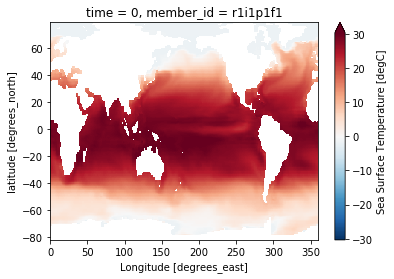

CAMS-CSM1-0
Progress: |███████████████████████████████████████████████████████████████████████████████| 100.0% 

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'
             
--> There are 1 group(s)
<xarray.DataArray 'tos' (member_id: 1, time: 1800, y: 200, x: 360)>
dask.array<broadcast_to, shape=(1, 1800, 200, 360), dtype=float32, chunksize=(1, 345, 200, 360), chunktype=numpy.ndarray>
Coordinates:
    lon        (y, x) float32 dask.array<chunksize=(200, 360), meta=np.ndarray>
    lat        (y, x) float32 dask.array<chunksize=(200, 360), meta=np.ndarray>
  * x          (x) float32 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
  * time       (time) float64 15.5 45.0 74.5 ... 5.467e+04 5.47e+04 5.473e+04
  * y          (y) float32 -81.5 -80.5 -79.5 ... 78.39897 78.67173 78.84095
  * member_id  (member_id) <U8 'r1i1p1f1'
Attributes:
    cell_measures:  area: areacello
    ce

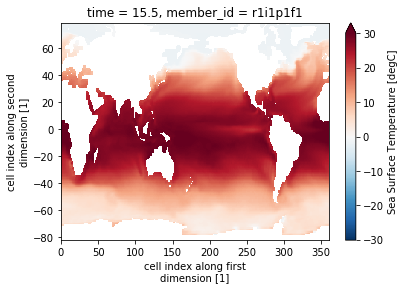

CanESM5
Progress: |███████████████████████████████████████████████████████████████████████████████| 100.0% 

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'
             
--> There are 1 group(s)
<xarray.DataArray 'agessc' (member_id: 1, time: 1812, lev: 45, y: 291, x: 360)>
dask.array<broadcast_to, shape=(1, 1812, 45, 291, 360), dtype=float32, chunksize=(1, 5, 45, 291, 360), chunktype=numpy.ndarray>
Coordinates:
    lon        (y, x) float64 dask.array<chunksize=(291, 360), meta=np.ndarray>
    lat        (y, x) float64 dask.array<chunksize=(291, 360), meta=np.ndarray>
  * lev        (lev) float64 3.047 9.454 16.36 ... 5.126e+03 5.375e+03 5.625e+03
  * x          (x) float64 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
  * time       (time) int64 0 708 1416 2148 ... 1319820 1320552 1321284 1322016
  * y          (y) float64 -78.39 -78.19 -77.98 -77.77 ... 71.57 71.62 71.6

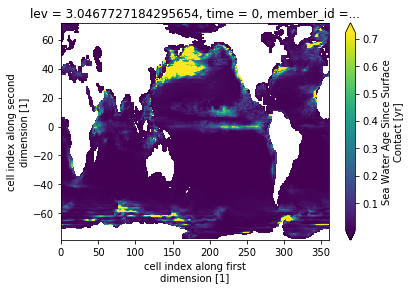

CanESM5-CanOE
Progress: |███████████████████████████████████████████████████████████████████████████████| 100.0% 

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'
             
--> There are 1 group(s)
<xarray.DataArray 'agessc' (member_id: 1, time: 1980, lev: 45, y: 291, x: 360)>
dask.array<broadcast_to, shape=(1, 1980, 45, 291, 360), dtype=float32, chunksize=(1, 5, 45, 291, 360), chunktype=numpy.ndarray>
Coordinates:
    lon        (y, x) float64 dask.array<chunksize=(291, 360), meta=np.ndarray>
    lat        (y, x) float64 dask.array<chunksize=(291, 360), meta=np.ndarray>
  * lev        (lev) float64 3.047 9.454 16.36 ... 5.126e+03 5.375e+03 5.625e+03
  * x          (x) float64 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
  * time       (time) int64 0 708 1416 2148 ... 1442460 1443192 1443924 1444656
  * y          (y) float64 -78.39 -78.19 -77.98 -77.77 ... 71.57 71.6

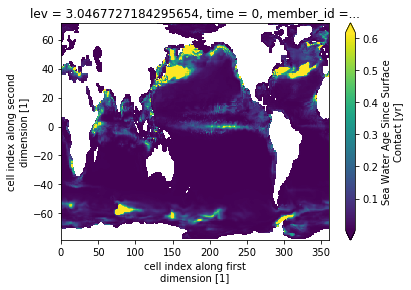

CNRM-CM6-1
Progress: |███████████████████████████████████████████████████████████████████████████████| 100.0% 

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'
             
--> There are 1 group(s)
<xarray.DataArray 'bigthetao' (member_id: 1, time: 1800, lev: 75, y: 294, x: 362)>
dask.array<broadcast_to, shape=(1, 1800, 75, 294, 362), dtype=float32, chunksize=(1, 8, 75, 294, 362), chunktype=numpy.ndarray>
Coordinates:
    lon        (y, x) float64 dask.array<chunksize=(294, 362), meta=np.ndarray>
    lat        (y, x) float64 dask.array<chunksize=(294, 362), meta=np.ndarray>
  * lev        (lev) float64 0.5058 1.556 2.668 ... 5.698e+03 5.902e+03
  * x          (x) float64 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
  * time       (time) int64 0 708 1416 2148 ... 1311924 1312656 1313388 1314120
  * y          (y) float64 -78.31 -78.13 -77.95 -77.76 ... 71.5 71.53 71.53
  

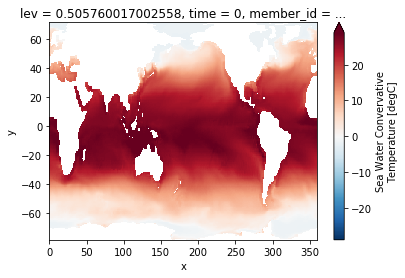

CNRM-ESM2-1
Progress: |███████████████████████████████████████████████████████████████████████████████| 100.0% 

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'
             
--> There are 1 group(s)
<xarray.DataArray 'chldiat' (member_id: 1, time: 1680, lev: 75, y: 294, x: 362)>
dask.array<broadcast_to, shape=(1, 1680, 75, 294, 362), dtype=float32, chunksize=(1, 4, 75, 294, 362), chunktype=numpy.ndarray>
Coordinates:
    lon        (y, x) float64 dask.array<chunksize=(294, 362), meta=np.ndarray>
    lat        (y, x) float64 dask.array<chunksize=(294, 362), meta=np.ndarray>
  * lev        (lev) float64 0.5058 1.556 2.668 ... 5.698e+03 5.902e+03
  * x          (x) float64 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
  * time       (time) int64 0 708 1416 2148 ... 1224276 1225008 1225740 1226472
  * y          (y) float64 -78.31 -78.13 -77.95 -77.76 ... 71.5 71.53 71.53
  *

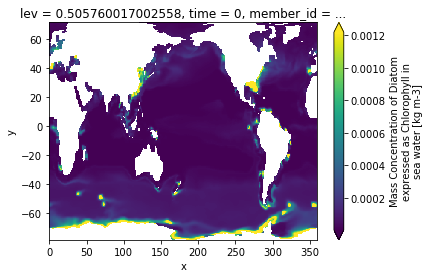

E3SM-1-0
Progress: |███████████████████████████████████████████████████████████████████████████████| 100.0% 

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'
             
--> There are 1 group(s)
<xarray.DataArray 'tos' (member_id: 1, time: 1800, y: 180, x: 360)>
dask.array<broadcast_to, shape=(1, 1800, 180, 360), dtype=float32, chunksize=(1, 648, 180, 360), chunktype=numpy.ndarray>
Coordinates:
    lon        (x, y) float64 0.5 0.5 0.5 0.5 0.5 ... 359.5 359.5 359.5 359.5
    lat        (x, y) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * x          (x) float64 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
  * time       (time) int64 0 708 1416 2148 ... 1311060 1311792 1312524 1313256
  * y          (y) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * member_id  (member_id) <U8 'r1i1p1f1'
Attributes:
    cell_measures:  area: areacello
    ce

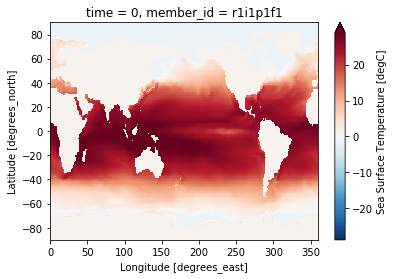

E3SM-1-1
Progress: |███████████████████████████████████████████████████████████████████████████████| 100.0% 

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'
             
--> There are 1 group(s)
<xarray.DataArray 'tos' (member_id: 1, time: 1980, y: 180, x: 360)>
dask.array<broadcast_to, shape=(1, 1980, 180, 360), dtype=float32, chunksize=(1, 326, 180, 360), chunktype=numpy.ndarray>
Coordinates:
    lon        (x, y) float64 0.5 0.5 0.5 0.5 0.5 ... 359.5 359.5 359.5 359.5
    lat        (x, y) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * x          (x) float64 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
  * time       (time) int64 0 708 1416 2148 ... 1442460 1443192 1443924 1444656
  * y          (y) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * member_id  (member_id) <U8 'r1i1p1f1'
Attributes:
    cell_measures:  area: areacello
    ce

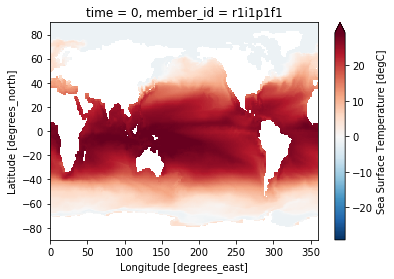

E3SM-1-1-ECA
Progress: |███████████████████████████████████████████████████████████████████████████████| 100.0% 

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'
             
--> There are 1 group(s)
<xarray.DataArray 'hfds' (member_id: 1, time: 1980, y: 180, x: 360)>
dask.array<broadcast_to, shape=(1, 1980, 180, 360), dtype=float32, chunksize=(1, 298, 180, 360), chunktype=numpy.ndarray>
Coordinates:
    lon        (x, y) float64 0.5 0.5 0.5 0.5 0.5 ... 359.5 359.5 359.5 359.5
    lat        (x, y) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * x          (x) float64 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
  * time       (time) int64 0 708 1416 2148 ... 1442460 1443192 1443924 1444656
  * y          (y) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * member_id  (member_id) <U8 'r1i1p1f1'
Attributes:
    cell_measures:  area: areacello
 

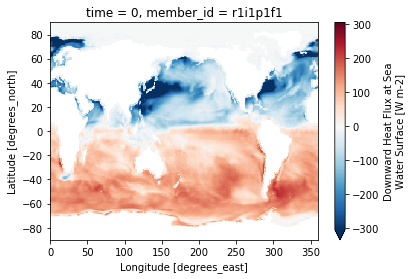

EC-Earth3-LR
Progress: |███████████████████████████████████████████████████████████████████████████████| 100.0% 

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'
             
--> There are 1 group(s)
<xarray.DataArray 'hfds' (member_id: 1, time: 12, y: 292, x: 362)>
dask.array<broadcast_to, shape=(1, 12, 292, 362), dtype=float32, chunksize=(1, 12, 292, 362), chunktype=numpy.ndarray>
Coordinates:
    lon        (y, x) float32 dask.array<chunksize=(292, 362), meta=np.ndarray>
    lat        (y, x) float32 dask.array<chunksize=(292, 362), meta=np.ndarray>
  * x          (x) float32 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
  * time       (time) int64 0 708 1416 2148 2880 ... 5088 5820 6552 7284 8016
  * y          (y) float32 -77.94583 -77.759056 -77.56907 ... 71.53102 71.53102
  * member_id  (member_id) <U8 'r1i1p1f1'
Attributes:
    cell_measures:   area: areacello
    

EC-Earth3-Veg
Progress: |███████████████████████████████████████████████████████████████████████████████| 100.0% 

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'
             
--> There are 1 group(s)
<xarray.DataArray 'bigthetao' (member_id: 1, time: 1812, lev: 75, y: 292, x: 362)>
dask.array<broadcast_to, shape=(1, 1812, 75, 292, 362), dtype=float32, chunksize=(1, 7, 75, 292, 362), chunktype=numpy.ndarray>
Coordinates:
    lon        (y, x) float64 dask.array<chunksize=(292, 362), meta=np.ndarray>
    lat        (y, x) float64 dask.array<chunksize=(292, 362), meta=np.ndarray>
  * lev        (lev) float64 0.5058 1.556 2.668 ... 5.698e+03 5.902e+03
  * x          (x) float64 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
  * time       (time) int64 0 708 1416 2148 ... 1320708 1321440 1322172 1322904
  * y          (y) float64 -77.95 -77.76 -77.57 -77.38 ... 71.5 71.53 71.53

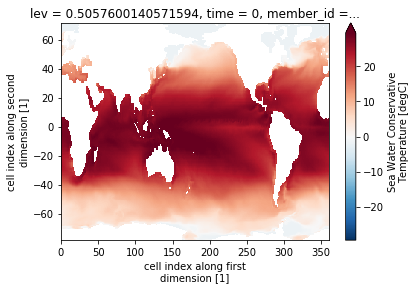

EC-Earth3
Progress: |███████████████████████████████████████████████████████████████████████████████| 100.0% 

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'
             
--> There are 1 group(s)
<xarray.DataArray 'so' (member_id: 1, time: 1980, lev: 75, y: 292, x: 362)>
dask.array<broadcast_to, shape=(1, 1980, 75, 292, 362), dtype=float32, chunksize=(1, 4, 75, 292, 362), chunktype=numpy.ndarray>
Coordinates:
    lon        (y, x) float32 dask.array<chunksize=(292, 362), meta=np.ndarray>
    lat        (y, x) float32 dask.array<chunksize=(292, 362), meta=np.ndarray>
  * lev        (lev) float64 0.5058 1.556 2.668 ... 5.698e+03 5.902e+03
  * x          (x) float32 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
  * time       (time) int64 0 708 1416 2148 ... 1443420 1444152 1444884 1445616
  * y          (y) float32 -77.94583 -77.759056 -77.56907 ... 71.53102 71.53102
  * me

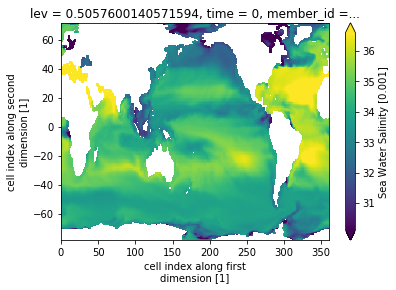

FGOALS-f3-L
Progress: |███████████████████████████████████████████████████████████████████████████████| 100.0% 

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'
             
--> There are 1 group(s)
<xarray.DataArray 'so' (member_id: 1, time: 1980, lev: 30, y: 218, x: 360)>
dask.array<broadcast_to, shape=(1, 1980, 30, 218, 360), dtype=float32, chunksize=(1, 10, 30, 218, 360), chunktype=numpy.ndarray>
Coordinates:
    lon        (y, x) float64 dask.array<chunksize=(218, 360), meta=np.ndarray>
    lat        (y, x) float64 dask.array<chunksize=(218, 360), meta=np.ndarray>
  * lev        (lev) float64 5.0 15.0 25.0 ... 3.856e+03 4.538e+03 5.244e+03
  * x          (x) float64 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
  * time       (time) float64 0.0 707.0 1.415e+03 ... 1.444e+06 1.445e+06
  * y          (y) float64 -75.99 -75.75 -75.5 -75.24 ... 71.91 72.11 72.24 72.3
  *

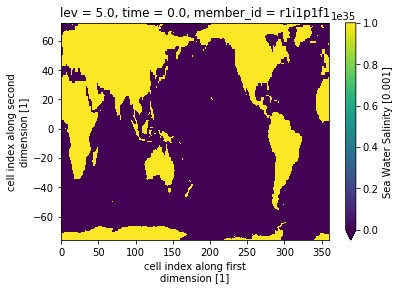

NICAM16-7S
Progress: |███████████████████████████████████████████████████████████████████████████████| 100.0% 

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'
             
--> There are 1 group(s)
<xarray.DataArray 'tos' (member_id: 1, time: 780, y: 320, x: 640)>
dask.array<broadcast_to, shape=(1, 780, 320, 640), dtype=float32, chunksize=(1, 141, 320, 640), chunktype=numpy.ndarray>
Coordinates:
    lon        (x, y) float64 0.2812 0.2812 0.2812 0.2812 ... 359.7 359.7 359.7
    lat        (x, y) float64 -89.72 -89.16 -88.59 -88.03 ... 88.59 89.16 89.72
  * x          (x) float64 0.2812 0.8438 1.406 1.969 ... 358.0 358.6 359.2 359.7
  * time       (time) int64 0 708 1416 2148 2880 ... 566844 567576 568308 569040
  * y          (y) float64 -89.72 -89.16 -88.59 -88.03 ... 88.59 89.16 89.72
  * member_id  (member_id) <U8 'r1i1p1f1'
Attributes:
    cell_measures:  area: areacello
    c

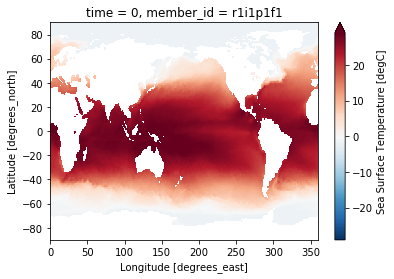

MIROC-ES2L
Progress: |███████████████████████████████████████████████████████████████████████████████| 100.0% 

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'
             
--> There are 1 group(s)
<xarray.DataArray 'fgco2' (member_id: 1, time: 1980, y: 256, x: 360)>
dask.array<broadcast_to, shape=(1, 1980, 256, 360), dtype=float32, chunksize=(1, 272, 256, 360), chunktype=numpy.ndarray>
Coordinates:
    lon        (y, x) float32 dask.array<chunksize=(256, 360), meta=np.ndarray>
    depth      float64 0.0
    lat        (y, x) float32 dask.array<chunksize=(256, 360), meta=np.ndarray>
  * x          (x) float32 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
  * time       (time) int64 0 708 1416 2148 ... 1443420 1444152 1444884 1445616
  * y          (y) float32 -88.0 -85.75 -85.25 ... 78.00103 78.0676 78.106964
  * member_id  (member_id) <U8 'r1i1p1f2'
Attributes:
    cell_m

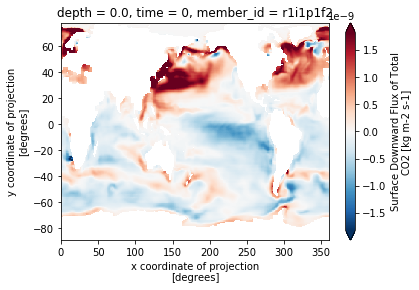

MIROC6
Progress: |-------------------------------------------------------------------------------| 0.0% MIROC6: No units found
Progress: |███████████████████████████████████████████████████████████████████████████████| 100.0% 

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'
             
--> There are 1 group(s)
<xarray.DataArray 'thetao' (member_id: 1, time: 1800, lev: 63, y: 256, x: 360)>
dask.array<broadcast_to, shape=(1, 1800, 63, 256, 360), dtype=float32, chunksize=(1, 6, 63, 256, 360), chunktype=numpy.ndarray>
Coordinates:
    lon        (y, x) float32 dask.array<chunksize=(256, 360), meta=np.ndarray>
    lat        (y, x) float32 dask.array<chunksize=(256, 360), meta=np.ndarray>
  * lev        (lev) float64 1.0 3.5 7.0 11.0 ... 6.24e+03 6.87e+03 7.25e+03
  * x          (x) float32 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
  * time       (time) int64 0 720 1440 2

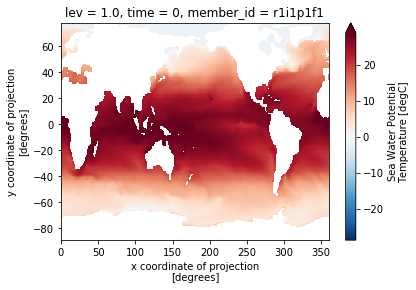

HadGEM3-GC31-LL
Progress: |███████████████████████████████████████████████████████████████████████████████| 100.0% 

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'
             
--> There are 1 group(s)
<xarray.DataArray 'agessc' (member_id: 1, time: 1800, lev: 75, y: 330, x: 360)>
dask.array<broadcast_to, shape=(1, 1800, 75, 330, 360), dtype=float32, chunksize=(1, 9, 75, 330, 360), chunktype=numpy.ndarray>
Coordinates:
    lon        (y, x) float32 dask.array<chunksize=(330, 360), meta=np.ndarray>
    lat        (y, x) float32 dask.array<chunksize=(330, 360), meta=np.ndarray>
  * lev        (lev) float64 0.5058 1.556 2.668 ... 5.698e+03 5.902e+03
  * x          (x) float32 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
  * time       (time) int64 0 30 60 90 120 150 ... 53850 53880 53910 53940 53970
  * y          (y) float32 -83.44534 -83.33822 -83.22936 ... 71.618454 71.6

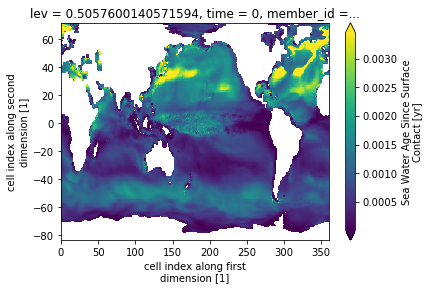

HadGEM3-GC31-MM
Progress: |███████████████████████████████████████████████████████████████████████████████| 100.0% 

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'
             
--> There are 1 group(s)
<xarray.DataArray 'hfds' (member_id: 1, time: 6000, y: 1205, x: 1440)>
dask.array<broadcast_to, shape=(1, 6000, 1205, 1440), dtype=float32, chunksize=(1, 16, 1205, 1440), chunktype=numpy.ndarray>
Coordinates:
    lon        (y, x) float32 dask.array<chunksize=(1205, 1440), meta=np.ndarray>
    lat        (y, x) float32 dask.array<chunksize=(1205, 1440), meta=np.ndarray>
  * x          (x) float32 0.25 0.5 0.75 1.0 1.25 ... 359.25 359.5 359.75 360.0
  * time       (time) int64 0 30 60 90 120 ... 179880 179910 179940 179970
  * y          (y) float32 -84.39374 -84.36955 -84.34527 ... 71.68596 71.68942
  * member_id  (member_id) <U8 'r1i1p1f1'
Attributes:
    cell_measures:  area: are

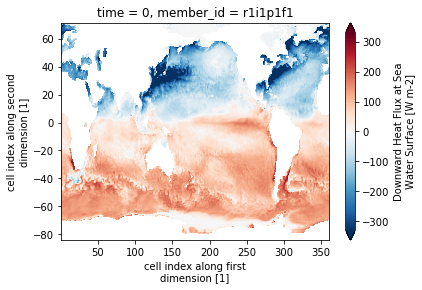

UKESM1-0-LL
Progress: |███████████████████████████████████████████████████████████████████████████████| 100.0% 

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'
             
--> There are 1 group(s)
<xarray.DataArray 'limirrdiat' (member_id: 1, time: 1800, y: 330, x: 360)>
dask.array<broadcast_to, shape=(1, 1800, 330, 360), dtype=float32, chunksize=(1, 233, 330, 360), chunktype=numpy.ndarray>
Coordinates:
    lon        (y, x) float32 dask.array<chunksize=(330, 360), meta=np.ndarray>
    lat        (y, x) float32 dask.array<chunksize=(330, 360), meta=np.ndarray>
  * x          (x) float32 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
  * time       (time) int64 0 30 60 90 120 150 ... 53850 53880 53910 53940 53970
  * y          (y) float32 -83.44534 -83.33822 -83.22936 ... 71.618454 71.65057
  * member_id  (member_id) <U8 'r1i1p1f2'
Attributes:
    cell_measures:  area: ar

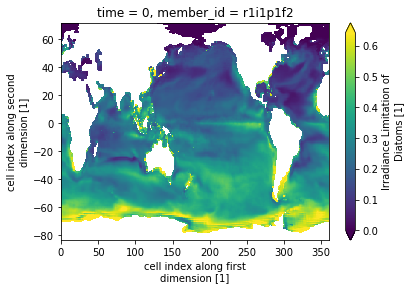

GISS-E2-2-G
Progress: |███████████████████████████████████████████████████████████████████████████████| 100.0% 

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'
             
--> There are 1 group(s)
<xarray.DataArray 'tos' (member_id: 1, time: 1812, y: 90, x: 144)>
dask.array<broadcast_to, shape=(1, 1812, 90, 144), dtype=float32, chunksize=(1, 962, 90, 144), chunktype=numpy.ndarray>
Coordinates:
    lon        (x, y) float64 1.25 1.25 1.25 1.25 ... 358.8 358.8 358.8 358.8
    lat        (x, y) float64 -89.0 -87.0 -85.0 -83.0 ... 83.0 85.0 87.0 89.0
  * x          (x) float64 1.25 3.75 6.25 8.75 11.25 ... 351.2 353.8 356.2 358.8
  * time       (time) int64 0 708 1416 2148 ... 1319820 1320552 1321284 1322016
  * y          (y) float64 -89.0 -87.0 -85.0 -83.0 -81.0 ... 83.0 85.0 87.0 89.0
  * member_id  (member_id) <U8 'r1i1p1f1'
Attributes:
    cell_measures:   area: areacello
    c

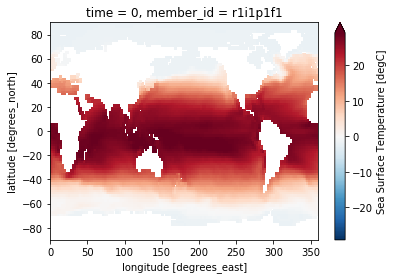

GISS-E2-1-G-CC
Progress: |███████████████████████████████████████████████████████████████████████████████| 100.0% 

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'
             
--> There are 1 group(s)
<xarray.DataArray 'agessc' (member_id: 1, time: 1980, lev: 40, y: 180, x: 288)>
dask.array<broadcast_to, shape=(1, 1980, 40, 180, 288), dtype=float32, chunksize=(1, 12, 40, 180, 288), chunktype=numpy.ndarray>
Coordinates:
    lon        (x, y) float64 0.625 0.625 0.625 0.625 ... 359.4 359.4 359.4
    lat        (x, y) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lev        (lev) float64 5.0 16.0 29.0 ... 4.453e+03 4.675e+03 4.897e+03
  * x          (x) float64 0.625 1.875 3.125 4.375 ... 355.6 356.9 358.1 359.4
  * time       (time) int64 0 708 1416 2148 ... 1442460 1443192 1443924 1444656
  * y          (y) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.

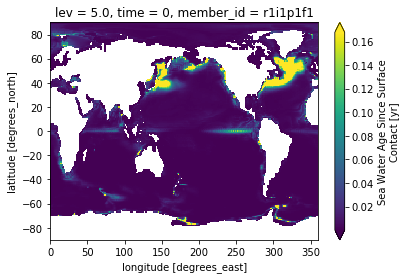

GISS-E2-1-G
Progress: |███████████████████████████████████████████████████████████████████████████████| 100.0% 

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'
             
--> There are 1 group(s)
<xarray.DataArray 'chldiat' (member_id: 1, time: 1812, lev: 40, y: 180, x: 288)>
dask.array<broadcast_to, shape=(1, 1812, 40, 180, 288), dtype=float32, chunksize=(1, 6, 40, 180, 288), chunktype=numpy.ndarray>
Coordinates:
    lon        (x, y) float64 0.625 0.625 0.625 0.625 ... 359.4 359.4 359.4
    lat        (x, y) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lev        (lev) float64 5.0 16.0 29.0 ... 4.453e+03 4.675e+03 4.897e+03
  * x          (x) float64 0.625 1.875 3.125 4.375 ... 355.6 356.9 358.1 359.4
  * time       (time) int64 0 708 1416 2148 ... 1319820 1320552 1321284 1322016
  * y          (y) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
 

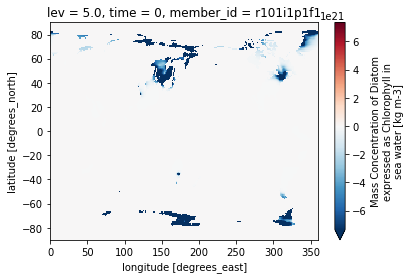

GISS-E2-1-H
Progress: |███████████████████████████████████████████████████████████████████████████████| 100.0% 

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'
             
--> There are 1 group(s)
<xarray.DataArray 'masscello' (member_id: 1, time: 1812, lev: 33, y: 180, x: 360)>
dask.array<broadcast_to, shape=(1, 1812, 33, 180, 360), dtype=float32, chunksize=(1, 5, 33, 180, 360), chunktype=numpy.ndarray>
Coordinates:
    lon        (x, y) float64 0.5 0.5 0.5 0.5 0.5 ... 359.5 359.5 359.5 359.5
    lat        (x, y) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lev        (lev) float64 0.0 10.0 20.0 30.0 ... 4e+03 4.5e+03 5e+03 5.5e+03
  * x          (x) float64 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
  * time       (time) int64 0 708 1416 2148 ... 1319820 1320552 1321284 1322016
  * y          (y) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88

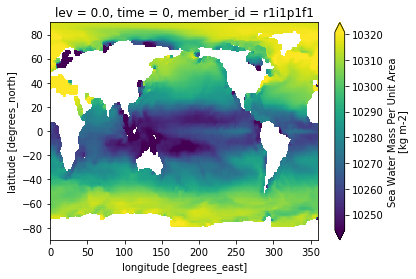

CESM1-1-CAM5-CMIP5
Progress: |███████████████████████████████████████████████████████████████████████████████| 100.0% 

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'
             
--> There are 1 group(s)
<xarray.DataArray 'fgco2' (member_id: 1, dcpp_init_year: 1, time: 122, y: 384, x: 320)>
dask.array<broadcast_to, shape=(1, 1, 122, 384, 320), dtype=float32, chunksize=(1, 1, 122, 384, 320), chunktype=numpy.ndarray>
Coordinates:
    lon             (y, x) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    lat             (y, x) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
  * dcpp_init_year  (dcpp_init_year) float64 1.96e+03
  * x               (x) float64 1.063 2.188 3.313 4.438 ... 357.7 358.8 359.9
  * time            (time) float64 0.0 4.317e+04 ... 5.255e+06 5.299e+06
  * y               (y) float64 -79.22 -78.69 -78.15 ... 77.21 77.21 77.22
  * membe

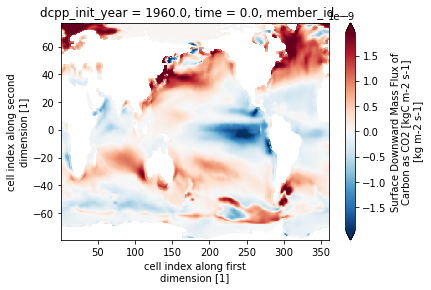

CESM2-WACCM
Progress: |-------------------------------------------------------------------------------| 0.0% CESM2-WACCM: Unexpected unit (centimeters) for coordinate `lev` detected.
	 Converted to `m`
Progress: |███████████████████████████████████████████████████████████████████████████████| 100.0% 

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'
             
--> There are 1 group(s)
<xarray.DataArray 'agessc' (member_id: 1, time: 1800, lev: 60, y: 384, x: 320)>
dask.array<broadcast_to, shape=(1, 1800, 60, 384, 320), dtype=float32, chunksize=(1, 7, 60, 384, 320), chunktype=numpy.ndarray>
Coordinates:
    lon        (y, x) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    lat        (y, x) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
  * lev        (lev) float64 5.0 15.0 25.0 ... 4.875e+03 5.125e+03 5.375e+03
  * x          (x) float64 1.063 2.188 3.313 4

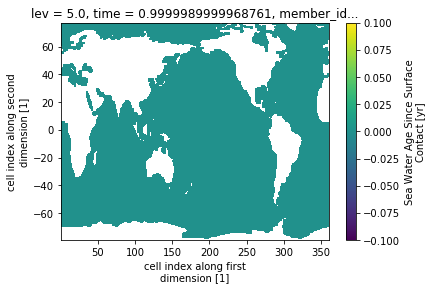

CESM2-WACCM-FV2
Progress: |-------------------------------------------------------------------------------| 0.0% CESM2-WACCM-FV2: Unexpected unit (centimeters) for coordinate `lev` detected.
	 Converted to `m`
Progress: |███████████████████████████████████████████████████████████████████████████████| 100.0% 

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'
             
--> There are 1 group(s)
<xarray.DataArray 'agessc' (member_id: 1, time: 1980, lev: 60, y: 384, x: 320)>
dask.array<broadcast_to, shape=(1, 1980, 60, 384, 320), dtype=float32, chunksize=(1, 3, 60, 384, 320), chunktype=numpy.ndarray>
Coordinates:
    lon        (y, x) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    lat        (y, x) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
  * lev        (lev) float64 5.0 15.0 25.0 ... 4.875e+03 5.125e+03 5.375e+03
  * x          (x) float64 1.063 2.188

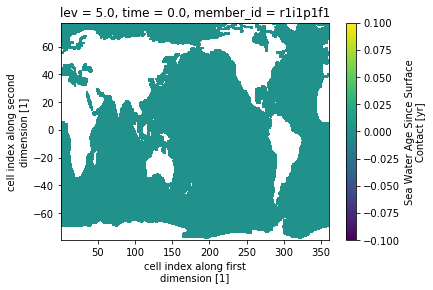

CESM2
Progress: |-------------------------------------------------------------------------------| 0.0% CESM2: Unexpected unit (centimeters) for coordinate `lev` detected.
	 Converted to `m`
Progress: |███████████████████████████████████████████████████████████████████████████████| 100.0% 

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'
             
--> There are 1 group(s)
<xarray.DataArray 'chldiat' (member_id: 1, time: 1800, lev: 15, y: 384, x: 320)>
dask.array<broadcast_to, shape=(1, 1800, 15, 384, 320), dtype=float32, chunksize=(1, 12, 15, 384, 320), chunktype=numpy.ndarray>
Coordinates:
    lon        (y, x) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    lat        (y, x) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
  * lev        (lev) float64 5.0 15.0 25.0 35.0 45.0 ... 115.0 125.0 135.0 145.0
  * x          (x) float64 1.063 2.188 3.313 4.438 .

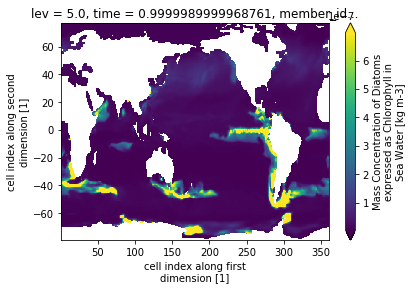

CESM2-FV2
Progress: |-------------------------------------------------------------------------------| 0.0% CESM2-FV2: Unexpected unit (centimeters) for coordinate `lev` detected.
	 Converted to `m`
Progress: |███████████████████████████████████████████████████████████████████████████████| 100.0% 

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'
             
--> There are 1 group(s)
<xarray.DataArray 'agessc' (member_id: 1, time: 1980, lev: 60, y: 384, x: 320)>
dask.array<broadcast_to, shape=(1, 1980, 60, 384, 320), dtype=float32, chunksize=(1, 3, 60, 384, 320), chunktype=numpy.ndarray>
Coordinates:
    lon        (y, x) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    lat        (y, x) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
  * lev        (lev) float64 5.0 15.0 25.0 ... 4.875e+03 5.125e+03 5.375e+03
  * x          (x) float64 1.063 2.188 3.313 4.438

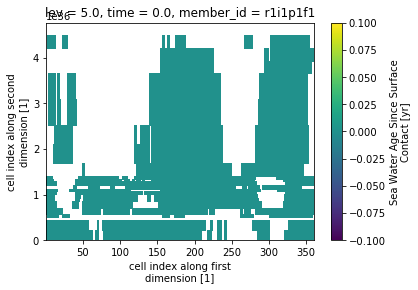

GFDL-CM4
Progress: |███████████████████████████████████████████████████████████████████████████████| 100.0% 

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'
             
--> There are 1 group(s)
<xarray.DataArray 'chl' (member_id: 1, time: 1800, lev: 35, y: 180, x: 360)>
dask.array<broadcast_to, shape=(1, 1800, 35, 180, 360), dtype=float32, chunksize=(1, 48, 35, 180, 360), chunktype=numpy.ndarray>
Coordinates:
    lon        (x, y) float64 0.5 0.5 0.5 0.5 0.5 ... 359.5 359.5 359.5 359.5
    lat        (x, y) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lev        (lev) float64 2.5 10.0 20.0 32.5 ... 5e+03 5.5e+03 6e+03 6.5e+03
  * x          (x) float64 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
  * time       (time) int64 0 708 1416 2148 ... 1311060 1311792 1312524 1313256
  * y          (y) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5


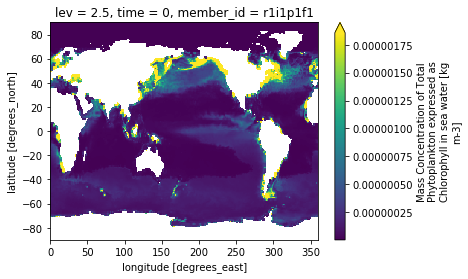

GFDL-OM4p5B
Progress: |███████████████████████████████████████████████████████████████████████████████| 100.0% 

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'
             
--> There are 1 group(s)
<xarray.DataArray 'o2' (member_id: 1, time: 3600, lev: 35, y: 180, x: 360)>
dask.array<broadcast_to, shape=(1, 3600, 35, 180, 360), dtype=float32, chunksize=(1, 14, 35, 180, 360), chunktype=numpy.ndarray>
Coordinates:
    lon        (x, y) float64 0.5 0.5 0.5 0.5 0.5 ... 359.5 359.5 359.5 359.5
    lat        (x, y) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lev        (lev) float64 2.5 10.0 20.0 32.5 ... 5e+03 5.5e+03 6e+03 6.5e+03
  * x          (x) float64 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
  * time       (time) int64 0 708 1416 2148 ... 2625060 2625792 2626524 2627256
  * y          (y) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.

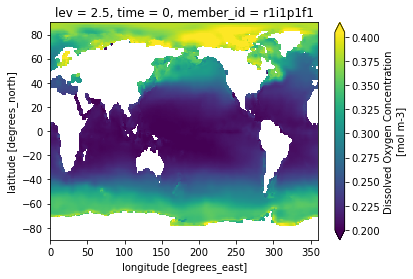

GFDL-ESM4
Progress: |███████████████████████████████████████████████████████████████████████████████| 100.0% 

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'
             
--> There are 1 group(s)
<xarray.DataArray 'chl' (member_id: 1, time: 1032, lev: 35, y: 180, x: 360)>
dask.array<broadcast_to, shape=(1, 1032, 35, 180, 360), dtype=float32, chunksize=(1, 12, 35, 180, 360), chunktype=numpy.ndarray>
Coordinates:
    lon        (x, y) float64 0.5 0.5 0.5 0.5 0.5 ... 359.5 359.5 359.5 359.5
    lat        (x, y) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lev        (lev) float64 2.5 10.0 20.0 32.5 ... 5e+03 5.5e+03 6e+03 6.5e+03
  * x          (x) float64 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
  * time       (time) int64 0 708 1416 2148 2880 ... 750420 751152 751884 752616
  * y          (y) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.

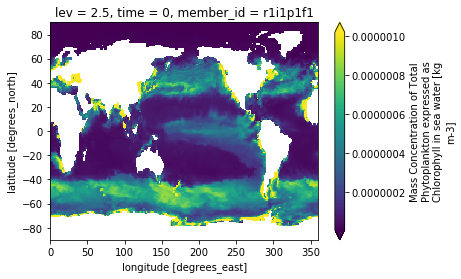

NESM3
Progress: |███████████████████████████████████████████████████████████████████████████████| 100.0% 

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'
             
--> There are 1 group(s)
<xarray.DataArray 'tos' (member_id: 1, time: 1800, y: 292, x: 362)>
dask.array<broadcast_to, shape=(1, 1800, 292, 362), dtype=float32, chunksize=(1, 430, 292, 362), chunktype=numpy.ndarray>
Coordinates:
    lon        (y, x) float32 dask.array<chunksize=(292, 362), meta=np.ndarray>
    lat        (y, x) float32 dask.array<chunksize=(292, 362), meta=np.ndarray>
  * x          (x) float32 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
  * time       (time) float64 15.5 45.0 74.5 ... 5.467e+04 5.47e+04 5.473e+04
  * y          (y) float32 -78.3935 -78.190575 -77.98418 ... 71.53102 71.53102
  * member_id  (member_id) <U8 'r1i1p1f1'
Attributes:
    cell_measures:  area: areacello
    cell_

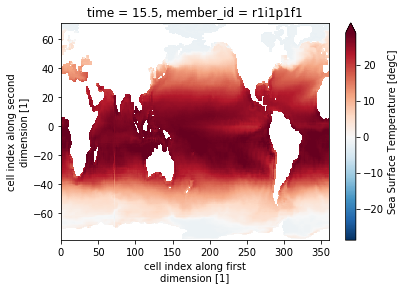

MRI-ESM2-0
Progress: |███████████████████████████████████████████████████████████████████████████████| 100.0% 

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'
             
--> There are 1 group(s)
<xarray.DataArray 'tos' (member_id: 1, time: 1812, y: 363, x: 360)>
dask.array<broadcast_to, shape=(1, 1812, 363, 360), dtype=float32, chunksize=(1, 374, 363, 360), chunktype=numpy.ndarray>
Coordinates:
    lon        (y, x) float64 dask.array<chunksize=(363, 360), meta=np.ndarray>
    lat        (y, x) float64 dask.array<chunksize=(363, 360), meta=np.ndarray>
  * x          (x) float64 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
  * time       (time) float64 15.5 45.0 74.5 ... 5.508e+04 5.511e+04 5.514e+04
  * y          (y) float64 -78.0 -77.5 -77.0 -76.5 ... 78.22 78.32 78.39 78.42
  * member_id  (member_id) <U8 'r1i1p1f1'
Attributes:
    cell_measures:  area: areacello
   

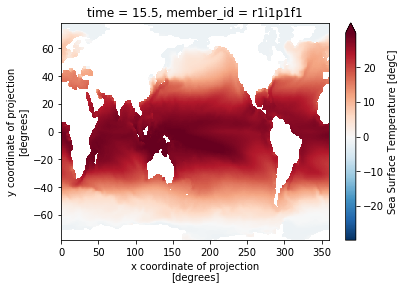

SAM0-UNICON
Progress: |███████████████████████████████████████████████████████████████████████████████| 100.0% 

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'
             
--> There are 1 group(s)
<xarray.DataArray 'agessc' (member_id: 1, time: 1800, lev: 60, y: 384, x: 320)>
dask.array<broadcast_to, shape=(1, 1800, 60, 384, 320), dtype=float32, chunksize=(1, 6, 60, 384, 320), chunktype=numpy.ndarray>
Coordinates:
    lon        (y, x) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    lat        (y, x) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
  * lev        (lev) float64 5.0 15.0 25.0 ... 4.875e+03 5.125e+03 5.375e+03
  * x          (x) float64 1.062 2.188 3.312 4.438 ... 356.6 357.7 358.8 359.9
  * time       (time) float64 0.0 4.173e+04 8.421e+04 ... 7.875e+07 7.879e+07
  * y          (y) float64 -79.22 -78.69 -78.15 -77.62 ... 77.21 77.21 77.22
  

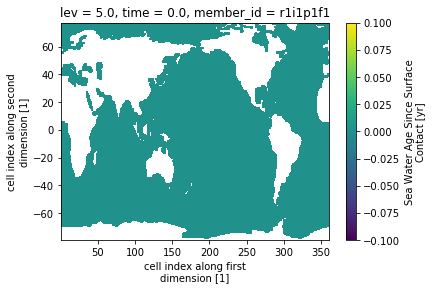

MCM-UA-1-0
Progress: |███████████████████████████████████████████████████████████████████████████████| 100.0% 

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'
             
--> There are 1 group(s)
<xarray.DataArray 'tos' (member_id: 1, time: 6000, y: 80, x: 192)>
dask.array<broadcast_to, shape=(1, 6000, 80, 192), dtype=float32, chunksize=(1, 1626, 80, 192), chunktype=numpy.ndarray>
Coordinates:
    lon        (x, y) float64 0.9375 0.9375 0.9375 0.9375 ... 359.1 359.1 359.1
    lat        (x, y) float64 -88.63 -86.13 -83.88 -81.63 ... 83.88 86.13 88.63
  * x          (x) float64 0.9375 2.812 4.688 6.562 ... 353.4 355.3 357.2 359.1
  * time       (time) int64 0 708 1416 2148 ... 4377060 4377792 4378524 4379256
  * y          (y) float64 -88.63 -86.13 -83.88 -81.63 ... 83.88 86.13 88.63
  * member_id  (member_id) <U8 'r1i1p1f1'
Attributes:
    cell_measures:  area: areacello
    cel

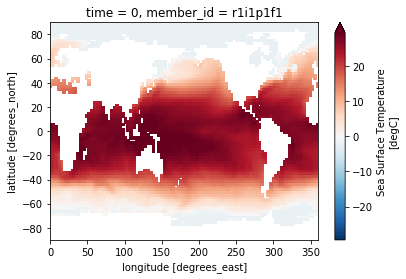

IPSL-CM6A-LR
Progress: |███████████████████████████████████████████████████████████████████████████████| 100.0% 

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'
             
--> There are 1 group(s)
<xarray.DataArray 'chldiat' (member_id: 1, time: 1800, lev: 75, y: 332, x: 362)>
dask.array<broadcast_to, shape=(1, 1800, 75, 332, 362), dtype=float32, chunksize=(1, 4, 75, 332, 362), chunktype=numpy.ndarray>
Coordinates:
    lon        (y, x) float32 dask.array<chunksize=(332, 362), meta=np.ndarray>
    lat        (y, x) float32 dask.array<chunksize=(332, 362), meta=np.ndarray>
  * lev        (lev) float32 0.50576 1.5558553 2.6676817 ... 5698.0605 5902.0576
  * x          (x) float32 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
  * time       (time) int64 0 708 1416 2148 ... 1311924 1312656 1313388 1314120
  * y          (y) float32 -83.554344 -83.44901 -83.3419 ... 71.53102

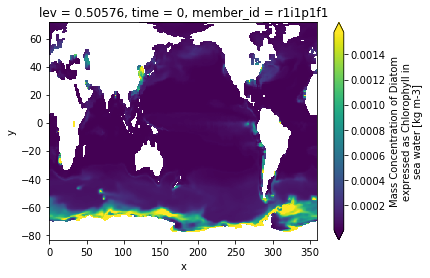

NorCPM1
Progress: |███████████████████████████████████████████████████████████████████████████████| 100.0% 

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'
             
--> There are 1 group(s)
<xarray.DataArray 'tos' (member_id: 1, time: 1968, y: 384, x: 320)>
dask.array<broadcast_to, shape=(1, 1968, 384, 320), dtype=float32, chunksize=(1, 205, 384, 320), chunktype=numpy.ndarray>
Coordinates:
    lon        (y, x) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    lat        (y, x) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
  * x          (x) float64 1.063 2.188 3.313 4.438 ... 356.6 357.7 358.8 359.9
  * time       (time) int64 0 708 1416 2148 ... 1433700 1434432 1435164 1435896
  * y          (y) float64 -79.22 -78.69 -78.15 -77.62 ... 77.21 77.21 77.22
  * member_id  (member_id) <U8 'r1i1p1f1'
Attributes:
    cell_measures:  area: areacello
    cell_

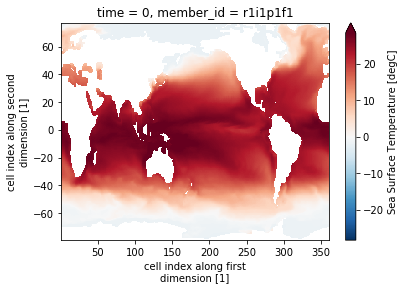

NorESM1-F
Progress: |███████████████████████████████████████████████████████████████████████████████| 100.0% 

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'
             
--> There are 1 group(s)
<xarray.DataArray 'dissic' (member_id: 1, time: 2400, rho: 53, y: 385, x: 360)>
dask.array<broadcast_to, shape=(1, 2400, 53, 385, 360), dtype=float32, chunksize=(1, 8, 53, 385, 360), chunktype=numpy.ndarray>
Coordinates:
    lon        (y, x) float64 dask.array<chunksize=(385, 360), meta=np.ndarray>
    lat        (y, x) float64 dask.array<chunksize=(385, 360), meta=np.ndarray>
  * rho        (rho) float64 1.027e+03 1.028e+03 ... 1.038e+03 1.038e+03
  * x          (x) float64 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
  * time       (time) int64 0 708 1416 2148 ... 1749060 1749792 1750524 1751256
  * y          (y) float64 -80.11 -79.94 -79.77 -79.59 ... 75.22 75.23 75.23
  * 

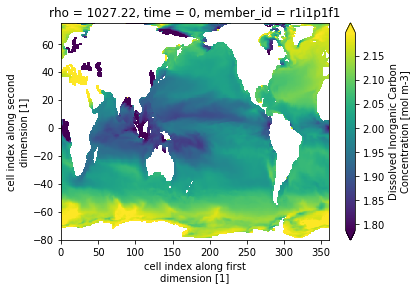

NorESM2-LM
Progress: |███████████████████████████████████████████████████████████████████████████████| 100.0% 

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'
             
--> There are 1 group(s)
<xarray.DataArray 'dissic' (member_id: 1, time: 1980, lev: 70, y: 385, x: 360)>
dask.array<broadcast_to, shape=(1, 1980, 70, 385, 360), dtype=float32, chunksize=(1, 5, 70, 385, 360), chunktype=numpy.ndarray>
Coordinates:
    lon        (y, x) float64 dask.array<chunksize=(385, 360), meta=np.ndarray>
    lat        (y, x) float64 dask.array<chunksize=(385, 360), meta=np.ndarray>
  * lev        (lev) float64 0.0 5.0 10.0 15.0 ... 6.25e+03 6.5e+03 6.75e+03
  * x          (x) float64 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
  * time       (time) int64 0 708 1416 2148 ... 1442460 1443192 1443924 1444656
  * y          (y) float64 -80.11 -79.94 -79.77 -79.59 ... 75.22 75.23 75.23

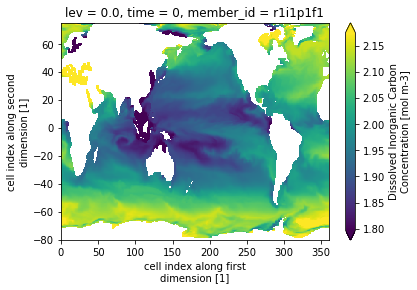

NorESM2-MM
Progress: |███████████████████████████████████████████████████████████████████████████████| 100.0% 

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'
             
--> There are 1 group(s)
<xarray.DataArray 'fgco2' (member_id: 1, time: 165, y: 385, x: 360)>
dask.array<broadcast_to, shape=(1, 165, 385, 360), dtype=float32, chunksize=(1, 82, 385, 360), chunktype=numpy.ndarray>
Coordinates:
    lon        (y, x) float64 dask.array<chunksize=(385, 360), meta=np.ndarray>
    lat        (y, x) float64 dask.array<chunksize=(385, 360), meta=np.ndarray>
  * x          (x) float64 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
  * time       (time) int64 0 365 730 1095 1460 ... 58765 59130 59495 59860
  * y          (y) float64 -80.11 -79.94 -79.77 -79.59 ... 75.22 75.23 75.23
  * member_id  (member_id) <U8 'r1i1p1f1'
Attributes:
    cell_measures:  area: areacello
    cell_

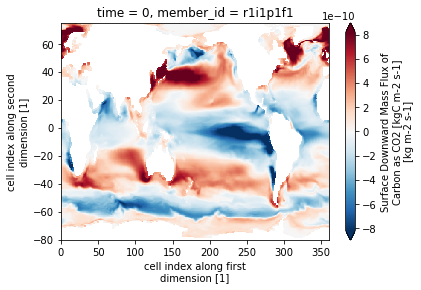

MPI-ESM1-2-HR
Progress: |███████████████████████████████████████████████████████████████████████████████| 100.0% 

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'
             
--> There are 1 group(s)
<xarray.DataArray 'chl' (member_id: 1, time: 1980, lev: 40, y: 404, x: 802)>
dask.array<broadcast_to, shape=(1, 1980, 40, 404, 802), dtype=float32, chunksize=(1, 2, 40, 404, 802), chunktype=numpy.ndarray>
Coordinates:
    lon        (y, x) float64 dask.array<chunksize=(404, 802), meta=np.ndarray>
    lat        (y, x) float64 dask.array<chunksize=(404, 802), meta=np.ndarray>
  * lev        (lev) float64 6.0 17.0 27.0 37.0 ... 4.67e+03 5.17e+03 5.72e+03
  * x          (x) float64 0.05388 0.5039 0.9539 1.404 ... 358.7 359.2 359.6
  * time       (time) int64 0 708 1416 2148 ... 1443420 1444152 1444884 1445616
  * y          (y) float64 -78.7 -78.3 -77.91 -77.52 ... 65.46 65.46 65.5 65.5

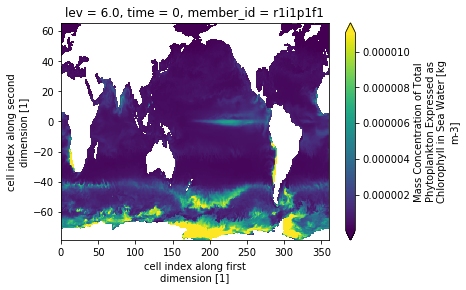

MPI-ESM1-2-LR
Progress: |███████████████████████████████████████████████████████████████████████████████| 100.0% 

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'
             
--> There are 1 group(s)
<xarray.DataArray 'chl' (member_id: 1, time: 165, lev: 40, y: 220, x: 256)>
dask.array<broadcast_to, shape=(1, 165, 40, 220, 256), dtype=float32, chunksize=(1, 14, 40, 220, 256), chunktype=numpy.ndarray>
Coordinates:
    lon        (y, x) float64 dask.array<chunksize=(220, 256), meta=np.ndarray>
    lat        (y, x) float64 dask.array<chunksize=(220, 256), meta=np.ndarray>
  * lev        (lev) float64 6.0 17.0 27.0 37.0 ... 4.67e+03 5.17e+03 5.72e+03
  * x          (x) float64 1.207 2.424 3.642 4.862 ... 356.3 357.6 358.8 360.0
  * time       (time) int64 0 8760 17532 26304 ... 1420068 1428840 1437600
  * y          (y) float64 -77.24 -76.96 -76.67 -76.37 ... 71.7 71.72 71.73
  * me

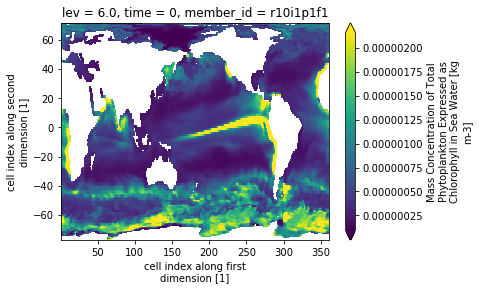

MPI-ESM-1-2-HAM
Progress: |███████████████████████████████████████████████████████████████████████████████| 100.0% 

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'
             
--> There are 1 group(s)
<xarray.DataArray 'chl' (member_id: 1, time: 165, lev: 40, y: 220, x: 256)>
dask.array<broadcast_to, shape=(1, 165, 40, 220, 256), dtype=float32, chunksize=(1, 14, 40, 220, 256), chunktype=numpy.ndarray>
Coordinates:
    lon        (y, x) float64 dask.array<chunksize=(220, 256), meta=np.ndarray>
    lat        (y, x) float64 dask.array<chunksize=(220, 256), meta=np.ndarray>
  * lev        (lev) float64 6.0 17.0 27.0 37.0 ... 4.67e+03 5.17e+03 5.72e+03
  * x          (x) float64 1.207 2.424 3.642 4.862 ... 356.3 357.6 358.8 360.0
  * time       (time) int64 0 8760 17532 26304 ... 1420068 1428840 1437600
  * y          (y) float64 -77.24 -76.96 -76.67 -76.37 ... 71.7 71.72 71.73
  * 

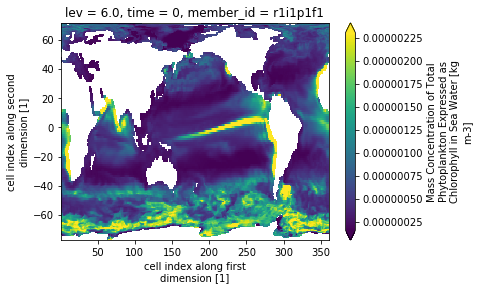

CNRM-CM6-1-HR
Progress: |███████████████████████████████████████████████████████████████████████████████| 100.0% 

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'
             
--> There are 1 group(s)
<xarray.DataArray 'bigthetao' (member_id: 1, time: 1800, lev: 75, y: 1050, x: 1442)>
dask.array<broadcast_to, shape=(1, 1800, 75, 1050, 1442), dtype=float32, chunksize=(1, 1, 75, 1050, 1442), chunktype=numpy.ndarray>
Coordinates:
    lon        (y, x) float32 dask.array<chunksize=(1050, 1442), meta=np.ndarray>
    lat        (y, x) float32 dask.array<chunksize=(1050, 1442), meta=np.ndarray>
  * lev        (lev) float64 0.5058 1.556 2.668 ... 5.698e+03 5.902e+03
  * x          (x) float32 0.25 0.5 0.75 1.0 1.25 ... 359.25 359.5 359.75 360.0
  * time       (time) int64 0 708 1416 2148 ... 1311924 1312656 1313388 1314120
  * y          (y) float32 -78.081795 -78.036 -77.99002 ... 71.655

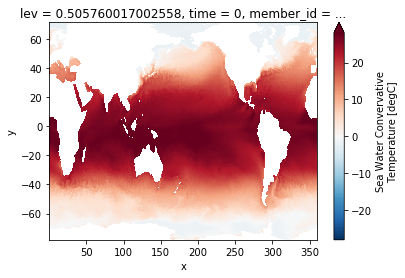

FIO-ESM-2-0
Progress: |███████████████████████████████████████████████████████████████████████████████| 100.0% 

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'
             
--> There are 1 group(s)
<xarray.DataArray 'so' (member_id: 1, time: 1980, lev: 60, y: 384, x: 320)>
dask.array<broadcast_to, shape=(1, 1980, 60, 384, 320), dtype=float32, chunksize=(1, 4, 60, 384, 320), chunktype=numpy.ndarray>
Coordinates:
    lon        (y, x) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    lat        (y, x) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
  * lev        (lev) float64 5.0 15.0 25.0 ... 4.875e+03 5.125e+03 5.375e+03
  * x          (x) float64 1.063 2.188 3.313 4.438 ... 356.6 357.7 358.8 359.9
  * time       (time) float64 0.0 4.235e+04 8.483e+04 ... 8.664e+07 8.668e+07
  * y          (y) float64 -79.22 -78.69 -78.15 -77.62 ... 77.21 77.21 77.22
  * me

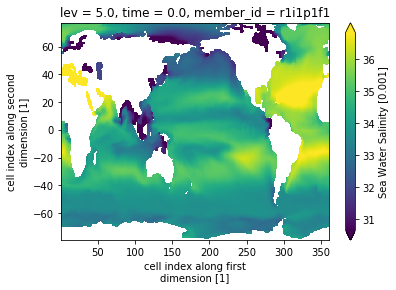

ACCESS-ESM1-5
Progress: |███████████████████████████████████████████████████████████████████████████████| 100.0% 

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'
             
--> There are 1 group(s)
<xarray.DataArray 'chl' (member_id: 1, time: 1032, lev: 50, y: 300, x: 360)>
dask.array<broadcast_to, shape=(1, 1032, 50, 300, 360), dtype=float32, chunksize=(1, 4, 50, 300, 360), chunktype=numpy.ndarray>
Coordinates:
    lon        (y, x) float64 dask.array<chunksize=(300, 360), meta=np.ndarray>
    lat        (y, x) float64 dask.array<chunksize=(300, 360), meta=np.ndarray>
  * lev        (lev) float64 5.0 15.0 25.0 ... 5.166e+03 5.499e+03 5.831e+03
  * x          (x) float64 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
  * time       (time) int64 0 708 1416 2148 2880 ... 750924 751656 752388 753120
  * y          (y) float64 -77.88 -77.63 -77.38 -77.13 ... 78.75 78.82 78.8

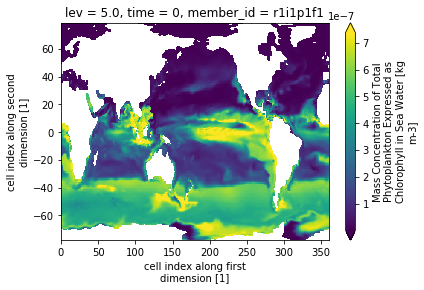

ACCESS-CM2
Progress: |███████████████████████████████████████████████████████████████████████████████| 100.0% 

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'
             
--> There are 1 group(s)
<xarray.DataArray 'tos' (member_id: 1, time: 1800, y: 300, x: 360)>
dask.array<broadcast_to, shape=(1, 1800, 300, 360), dtype=float32, chunksize=(1, 201, 300, 360), chunktype=numpy.ndarray>
Coordinates:
    lon        (y, x) float64 dask.array<chunksize=(300, 360), meta=np.ndarray>
    lat        (y, x) float64 dask.array<chunksize=(300, 360), meta=np.ndarray>
  * x          (x) float64 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
  * time       (time) int64 0 708 1416 2148 ... 1311924 1312656 1313388 1314120
  * y          (y) float64 -77.88 -77.63 -77.38 -77.13 ... 78.75 78.82 78.86
  * member_id  (member_id) <U8 'r1i1p1f1'
Attributes:
    cell_measures:  area: areacello
    

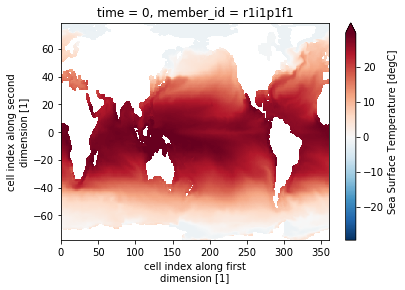

INM-CM4-8
Progress: |███████████████████████████████████████████████████████████████████████████████| 100.0% 

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'
             
--> There are 1 group(s)
<xarray.DataArray 'tos' (member_id: 1, time: 1800, y: 180, x: 360)>
dask.array<broadcast_to, shape=(1, 1800, 180, 360), dtype=float32, chunksize=(1, 382, 180, 360), chunktype=numpy.ndarray>
Coordinates:
    lon        (x, y) float64 0.5 0.5 0.5 0.5 0.5 ... 359.5 359.5 359.5 359.5
    lat        (x, y) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * x          (x) float64 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
  * time       (time) int64 0 708 1416 2148 ... 1311060 1311792 1312524 1313256
  * y          (y) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * member_id  (member_id) <U8 'r1i1p1f1'
Attributes:
    cell_measures:  area: areacello
    c

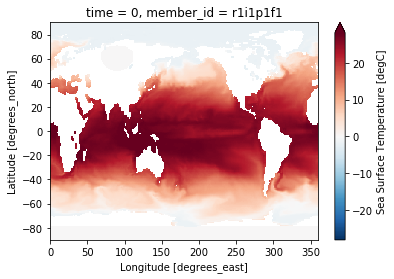

INM-CM5-0
Progress: |███████████████████████████████████████████████████████████████████████████████| 100.0% 

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'
             
--> There are 1 group(s)
<xarray.DataArray 'uo' (member_id: 1, time: 14412, lev: 33, y: 180, x: 360)>
dask.array<broadcast_to, shape=(1, 14412, 33, 180, 360), dtype=float32, chunksize=(1, 12, 33, 180, 360), chunktype=numpy.ndarray>
Coordinates:
    lon        (x, y) float64 0.5 0.5 0.5 0.5 0.5 ... 359.5 359.5 359.5 359.5
    lat        (x, y) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lev        (lev) float64 0.0 10.0 20.0 30.0 ... 4e+03 4.5e+03 5e+03 5.5e+03
  * x          (x) float64 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
  * time       (time) int64 0 708 1416 2148 ... 10518552 10519284 10520016
  * y          (y) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  *

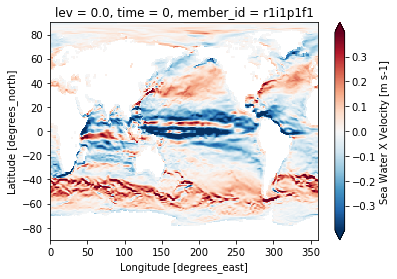

CIESM
Progress: |███████████████████████████████████████████████████████████████████████████████| 100.0% 

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'
             
--> There are 1 group(s)
<xarray.DataArray 'zos' (member_id: 1, time: 1044, y: 384, x: 320)>
dask.array<broadcast_to, shape=(1, 1044, 384, 320), dtype=float32, chunksize=(1, 107, 384, 320), chunktype=numpy.ndarray>
Coordinates:
    lon        (y, x) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    lat        (y, x) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
  * x          (x) float64 1.062 2.188 3.312 4.438 ... 356.6 357.7 358.8 359.9
  * time       (time) int64 0 708 1416 2148 2880 ... 750420 751152 751884 752616
  * y          (y) float64 -79.22 -78.69 -78.15 -77.62 ... 77.21 77.21 77.22
  * member_id  (member_id) <U8 'r1i1p1f1'
Attributes:
    cell_measures:  area: areacello
    cell_m

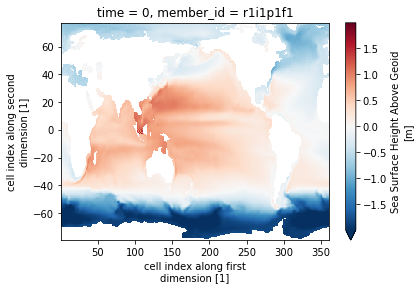

KACE-1-0-G
Progress: |███████████████████████████████████████████████████████████████████████████████| 100.0% 

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'
             
--> There are 1 group(s)
<xarray.DataArray 'tos' (member_id: 1, time: 1812, y: 200, x: 360)>
dask.array<broadcast_to, shape=(1, 1812, 200, 360), dtype=float32, chunksize=(1, 352, 200, 360), chunktype=numpy.ndarray>
Coordinates:
    lon        (y, x) float64 dask.array<chunksize=(200, 360), meta=np.ndarray>
    lat        (y, x) float64 dask.array<chunksize=(200, 360), meta=np.ndarray>
  * x          (x) float64 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
  * time       (time) int64 0 30 60 90 120 150 ... 54210 54240 54270 54300 54330
  * y          (y) float64 -81.5 -80.5 -79.5 -78.5 ... 78.05 78.4 78.67 78.84
  * member_id  (member_id) <U8 'r1i1p1f1'
Attributes:
    cell_measures:  area: areacello
  

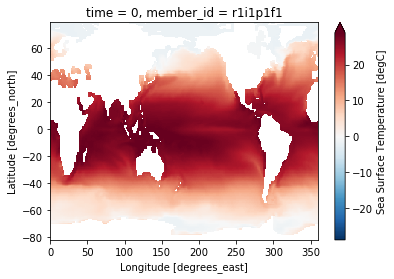

In [7]:
from xmip.preprocessing import combined_preprocessing
# currently cmip6_pp cant deal with 2d (depth, lat ) variables...should
# be fixed

# I should also independently test for gn and gr variables
test_vars = [v for v in all_variables if v not in ['msftmz']]

for model in models:
    if 'AWI' not in model:
        print(model)
        cat_check = col.search(source_id=model,
                               variable_id=test_vars,
                               **query)
        cat_check.df = cat_check.df.drop_duplicates(subset='source_id')
        check = cat_check.to_dataset_dict(
            zarr_kwargs={'consolidated': True, 'decode_times':False},
            preprocess=combined_preprocessing
        )
        ds = check[list(check.keys())[0]]
        var = ds.attrs['variable_id']
        da = ds[var]
        print(da)
        for di in ['time', 'member_id', 'lev', 'rho']:
            if di in da.dims:
                da = da.isel({di:0})
                
        plt.figure()
        da.plot(robust=True)
        plt.show()